In [1]:
import matplotlib.pyplot as plt
from spider import SPIDER
op = SPIDER()
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import os

2023-06-22 17:27:09.698592: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 17:27:09.700544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 17:27:09.738412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 17:27:09.740379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 17:27:10.469814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
304/1919 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
562/1911 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
729/1903 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
304/1919 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03


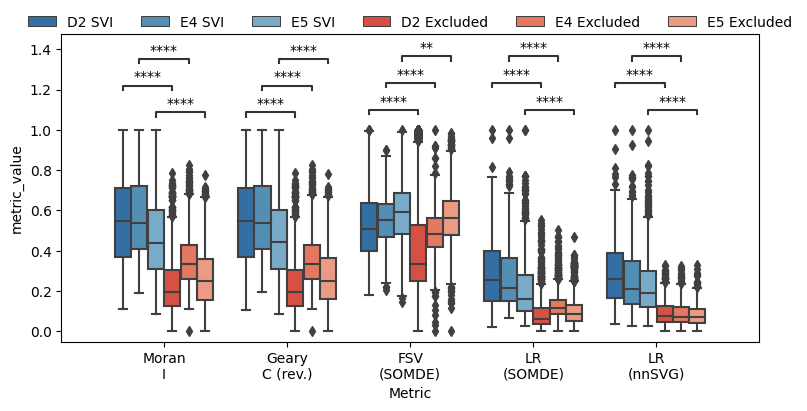

In [5]:
ds = 'mouse_lung'
boxdf = []
for sample_name in os.listdir(f'../datasets/{ds}/'):
    out_f = f'../datasets/{ds}/{sample_name}/'
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
    methods = np.array(['moranI', 'gearyC', 'SOMDE', 'nnSVG'])[np.isin(['SOMDE', 'nnSVG', 'gearyC', 'moranI'],list(idata.uns.keys()))]
    print(f'evaluating with {methods}')
    dfs = []
    metrics = []
    for i in methods:
        if i == 'gearyC':
            dfs.append(-idata.uns['gearyC'][['C']])
            metrics.append("Geary\nC (rev.)")
        elif i == 'moranI':
            dfs.append(idata.uns['moranI'][['I']]),
            metrics.append("Moran\nI")
        elif i == 'SOMDE':
            dfs.append(idata.uns['SOMDE'].set_index('g')['FSV']),
            metrics.append("FSV\n(SOMDE)") 
            dfs.append(idata.uns['SOMDE'].set_index('g')['LLR']),
            metrics.append("LR\n(SOMDE)") 
        elif i == 'nnSVG':
            # dfs.append(idata.uns['nnSVG']['prop_sv']),
            # metrics.append("FSV\n(nnSVG)") 
            dfs.append(idata.uns['nnSVG']['LR_stat']),
            metrics.append("LR\n(nnSVG)") 
    df = pd.concat(dfs, axis=1)
    df.columns=metrics

    normalized_df=(df-df.min())/(df.max()-df.min())
    normalized_df['Category'] = f'{sample_name} Excluded'
    normalized_df.loc[svi_df_strict.index, 'Category'] = f'{sample_name} SVI'
    normalized_df = normalized_df.melt(id_vars='Category', value_vars=metrics, var_name='Metric')
    boxdf.append(normalized_df)

import seaborn as sns
from statannotations.Annotator import Annotator
sumdf=pd.concat(boxdf,axis=0)
pairs = []
for i in metrics:
    pairs.append( ((i, 'D2 SVI'), (i, 'D2 Excluded')) )
    pairs.append( ((i, 'E4 SVI'), (i, 'E4 Excluded')) )
    pairs.append( ((i, 'E5 SVI'), (i, 'E5 Excluded')) )
sumdf_copy = sumdf.copy().dropna()
sumdf['metric_value'] = sumdf['value'] 

plt.figure(figsize=(9, 4))
ax =sns.boxplot(data=sumdf,x='Metric',y='metric_value', hue='Category', palette={
    'D2 SVI':'#2171b5','E4 SVI':'#4292c6','E5 SVI':'#6baed6',
    'D2 Excluded': '#ef3b2c','E4 Excluded': '#fb6a4a','E5 Excluded': '#fc9272',
}, width=0.8, hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
ax.legend(loc='upper center',ncol=6, bbox_to_anchor=(0.5, 1.1), frameon=False)
annot = Annotator(ax, pairs, data=sumdf, x='Metric',y='value', hue='Category', hue_order=['D2 SVI', 'E4 SVI','E5 SVI','D2 Excluded', 'E4 Excluded','E5 Excluded',])
annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
annot.apply_test()
annot.annotate()
plt.savefig(f'../figures/mouse_lung_metric.png', dpi=300,bbox_inches='tight')

In [10]:
ds = 'mouse_lung'
for sample_name in os.listdir(f'../datasets/{ds}/'):
    out_f = f'../datasets/{ds}/{sample_name}/'
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
    op.svi.eva_SVI(idata, svi_df_strict)
    plt.savefig(f'../figures/{ds}_{sample_name}_metric.png', dpi=300,bbox_inches='tight')
    plt.close()
    
    op.util.adata_moranI(adata, out_f=out_f)
    merged_df,lri_pw_list,gene_lr_list,gene_pw_list = op.vis.svg_svi_relation(adata, idata, title=sample_name, is_human=adata.uns['is_human'], top=50)
    plt.savefig(f'../figures/{ds}_{sample_name}_relation.png', dpi=300,bbox_inches='tight')
    plt.close()
    
    import gseapy
    membership=pd.get_dummies(merged_df.set_index('Term')['group']).groupby('Term').sum().astype(str).agg('-'.join, axis=1)
    merged_df['group name'] = membership.loc[merged_df.Term].to_numpy()
    rename_dict = {
        '1-0-0': 'LR', '1-0-1':'SVI&LR', '0-0-1':'SVI', '1-1-1':'All', '0-1-0':'SVG', '0-1-1':'SVI&SVG'
    }
    merged_df['group name'] = merged_df['group name'] .astype('category').cat.rename_categories(rename_dict).to_numpy()
    op.vis.enrichment(merged_df,x_key='group name', cutoff=0.05, top_term=20,size=15,save=f'../figures/{ds}_{sample_name}_relation_enrichment.png')
            
    op.vis.pattern_LRI(idata,show_SVI=10, spot_size=1)
    plt.tight_layout()
    plt.savefig(f'../figures/{ds}_{sample_name}_patterns.png', dpi=300,bbox_inches='tight')
    plt.close()
    
    op.svi.eva_pattern(idata)
    plt.savefig(f'../figures/{ds}_{sample_name}_pattern_metric.png', dpi=300,bbox_inches='tight')
    plt.close()
    
    merged_df_edge, arr = op.er.pattern_enrichment_edge(idata,is_human=adata.uns['is_human'])
    merged_df_node, arr = op.er.pattern_enrichment_node(idata,is_human=adata.uns['is_human'])
    op.vis.enrichment(merged_df_node,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_node.png',size=15)
    try:
        op.vis.enrichment(merged_df_edge,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_edge.png')
    except Exception as e:
        print(e)
    
    idata = idata[:, idata.var['is_svi']==1]
    adata.obs[['row', 'col']] = adata.obs[['row', 'col']].astype(int)
    adata, adata_lri, adata_pattern = op.cell_transform(idata, adata, label=adata.uns['cluster_key'])
    adata_lri.obs[['row', 'col']] = adata_lri.obs[['row', 'col']].astype(int)
    adata_pattern.obs[['row', 'col']] = adata_pattern.obs[['row', 'col']].astype(int)
    
    
    with plt.rc_context():
        sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI.png', bbox_inches="tight")
        plt.close()
        
    with plt.rc_context():
        sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', n_genes=1, show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI1.png', bbox_inches="tight")
        plt.close()
        
    with plt.rc_context(): 
        sc.pl.rank_genes_groups_dotplot(adata_pattern, standard_scale='var', n_genes=1, show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_pattern.png', bbox_inches="tight")
        plt.close()
        
    from scipy import stats
    pds = []
    for i in adata_lri.var_names:
        pds.append(pd.get_dummies(adata.obs['annotation']).corrwith(adata_lri.to_df()[i].astype('float'), method=stats.pointbiserialr)[:1])
    pds_df = pd.concat(pds)
    pds_df.index = adata_lri.var_names
    useful_df = []
    # plt.rcParams.update({'font.size': 14})
    for cluster_i in adata.obs['annotation'].unique():
        df_sub = pds_df[pds_df[cluster_i]>0.5][cluster_i].sort_values(ascending=False)
        if len(df_sub) > 0:
            useful_df.append(df_sub)
            markers = df_sub.index.to_numpy()[:10]
            corrs = df_sub.values[:10]
            cluster_name = df_sub.name
            plt.figure(figsize=(4*(len(markers)+1), 4))
            base = 1
            plt.subplot(1, len(markers)+1, base)

            plt.scatter(adata.obs['row'],adata.obs['col'], c=adata.obs['annotation']==cluster_i, s=0.5, cmap='plasma')
            plt.axis('equal')
            plt.axis('off')
            plt.title(f'{cluster_name}\n({sample_name})')
            base += 1

            marker_score = adata_lri.to_df()[markers]
            marker_score = pd.concat([adata_lri.obs[['row', 'col']], marker_score], axis=1)
            for i in range(len(markers)):
                plt.subplot(1, len(markers)+1, base)
                im=plt.scatter(marker_score['row'],marker_score['col'], c=marker_score[markers[i]], s=0.5, cmap='plasma')
                plt.colorbar(im,fraction=0.046, pad=0.04)
                plt.axis('equal')
                plt.axis('off')
                plt.title(f'{markers[i]}\ncorr={"%.3f" % corrs[i]}')
                base += 1
            plt.savefig(f'../figures/{ds}_{sample_name}_{cluster_name}.png', dpi=300,bbox_inches='tight')
            plt.close()    

    corr_df = pd.concat([adata.to_df()[['Scgb1a1', 'Scgb3a2', 'Cyp2f2', 'Hp']].loc[adata_lri.obs_names], adata_lri.to_df()], axis=1).corr(method='pearson')
    corr_df_asyn =  corr_df.loc[adata_lri.var_names, ['Scgb1a1', 'Scgb3a2', 'Cyp2f2', 'Hp']]
    # plt.rcParams.update({'font.size': 15})

    corrs = corr_df_asyn.mean(1).sort_values(ascending=False).values[:10]
    lris = corr_df_asyn.mean(1).sort_values(ascending=False).index[:10]
    marker_score = adata_lri.to_df()[lris]
    adata.obs[['row', 'col']] = adata.obs[['row', 'col']].astype(int)
    adata_lri.obs[['row', 'col']] = adata_lri.obs[['row', 'col']].astype(int)

    plt.figure(figsize=(44, 4))
    base=1
    plt.subplot(1, 11, base)
    im=plt.scatter(adata.obs['row'],adata.obs['col'], c=adata.to_df()['Scgb1a1'], s=0.05, cmap='plasma',vmin=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title('Bronchioli\nScgb1a1')
    base+=1
    for i in range(len(lris)):
        plt.subplot(1, 11, base)
        im=plt.scatter(adata_lri.obs['row'],adata_lri.obs['col'], c=marker_score[lris[i]], s=0.05, cmap='plasma')
        plt.colorbar(im,fraction=0.046, pad=0.04)
        plt.axis('equal')
        plt.axis('off')
        plt.title(f'{lris[i]} \n corr={"%.3f" % corrs[i]}')
        base += 1
    plt.tight_layout()
    plt.savefig(f'../figures/{ds}_{sample_name}_BronchioliMarker.png', dpi=300,bbox_inches='tight')
    plt.close()
    

Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
562/1911 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Geary
C (rev.)_SVI vs. Geary
C (rev.)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=6.251e+05
Moran
I_SVI vs. Moran
I_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=6.249e+05
FSV
(SOMDE)_SVI vs. FSV
(SOMDE)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=4.843e+05
LR
(SOMDE)_SVI vs. LR
(SOMDE)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=6.209e+05
LR
(nnSVG)_SVI vs. L









































































































































































































































































































































































































































































































































































































































































































100%|██████████| 1000/1000 [08:20<00:00,  2.00/s]


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.4769267854294617 0.2797244309551748 0.17008704592674959
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5_no vs. 5_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.552e-117 U_stat=2.507e+03
6_no vs. 6_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.046e-32 U_stat=1.892e+03
7_no vs. 7_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.842e-07 U_stat=0.000e+00
8_no vs. 8_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.678e-58 U_stat=1.999e+03
1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.642e-157 U_stat=2.870e+02
2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:






























































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 1000/1000 [06:14<00:00,  2.67/s]


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.5168494061429587 0.3221446908617091 0.1968706981255299
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_no vs. 9_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.339e-10 U_stat=3.650e+02
10_no vs. 10_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.413e-32 U_stat=2.942e+03
11_no vs. 11_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.375e-07 U_stat=7.470e+02
12_no vs. 12_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.577e-03 U_stat=0.000e+00
13_no vs. 13_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.504e-11 U_stat=1.890e+02
14_no vs. 14_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction,

2023-06-22 14:32:46,667 [ERROR] Error fetching enrichment results: KEGG_2019_Mouse
2023-06-22 14:32:47,076 [ERROR] Error fetching enrichment results: KEGG_2019_Mouse


Expecting value: line 1 column 1 (char 0)
Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns
         Falling back to preprocessing with `sc.pp.pca` and default params.
